In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import os
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import auc
from shot_benchmarks.utils import metrics
from shot_benchmarks.detectors.ffprobe_shots import extract_shots_with_ffprobe
from shot_benchmarks.detectors.shotdetect_shots import extract_shots_with_shotdetect
from shot_benchmarks.detectors.shotdetect_shots import extract_boundaries_from_shotdetect_output
from shot_benchmarks.detectors.pyscenedetect_shots import extract_shots_with_pyscenedetect

###Test Data

The test data consists of three youtube videos:

* [football clip](https://www.youtube.com/watch?v=vFT8HXJlvfA) (05:11) 
* [movie clip](https://www.youtube.com/watch?v=bpLtXIlkyYA) (03:12)
* [gameshow clip](https://www.youtube.com/watch?v=fkiDpLlQ9Wg) (29:45, but only first 05:00 used)

A shot boundary prediction is considered correct if it lies within the number of seconds given by `TOLERANCE` of the human annotated boundary

#PR curves with defaults

###Gameshow clip

In [17]:
video = 'gameshow'
TOLERANCE = 0.2 

In [18]:
parent_dir = os.path.abspath('..')
src_video = '{}/raw/{}.mp4'.format(parent_dir, video)

Load human annotations

In [19]:
annotations_csv = '{}/annotations/{}.csv'.format(parent_dir, video)
gt_shot_boundaries = metrics.get_ground_truth(annotations_csv)
num_pos = len(gt_shot_boundaries)

Much of the work involved in shot detection involves tuning the threshold parameters of the shot detection tool.  Before tuning these, each is run with its suggested default.

In [20]:
ffprobe_threshold = 0.3
shotdetect_threshold = 60
pyscenedetect_threshold = 30

FFprobe predictions

In [21]:
ff_predictions = extract_shots_with_ffprobe(src_video, threshold=ffprobe_threshold)
ff_ranked_predictions = sorted(ff_predictions, key=lambda x: x[1], reverse=True)
ff_results = metrics.evaluate_shot_predictions(ff_ranked_predictions, gt_shot_boundaries, tolerance=TOLERANCE)
ff_precision, ff_recall = metrics.get_precision_recall(ff_results, num_pos)
ff_auc = auc(ff_recall, ff_precision)

Shotdetect predictions

In [22]:
sd_predictions = extract_shots_with_shotdetect(src_video, video, threshold=shotdetect_threshold)
sd_ranked_predictions = sorted(sd_predictions, key=lambda x: x[1], reverse=True)
sd_results = metrics.evaluate_shot_predictions(sd_ranked_predictions, gt_shot_boundaries, tolerance=TOLERANCE)
sd_precision, sd_recall = metrics.get_precision_recall(sd_results, num_pos)
sd_auc = auc(sd_recall, sd_precision)

PySceneDetect predictions

In [23]:
psd_predictions = extract_shots_with_pyscenedetect(src_video, threshold=pyscenedetect_threshold, min_scene_length=15)
psd_ranked_predictions = sorted(psd_predictions, key=lambda x: x[1], reverse=True)
psd_results = metrics.evaluate_shot_predictions(psd_ranked_predictions, gt_shot_boundaries, tolerance=TOLERANCE)
psd_precision, psd_recall = metrics.get_precision_recall(psd_results, num_pos)
psd_auc = auc(psd_recall, psd_precision)

[PySceneDetect] Parsing video gameshow.mp4...
[PySceneDetect] Video Resolution / Framerate: 384 x 288 / 25.000 FPS
Verify that the above parameters are correct (especially framerate, use --force-fps to correct if required).


In [24]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 11.5}
matplotlib.rc('font', **font)

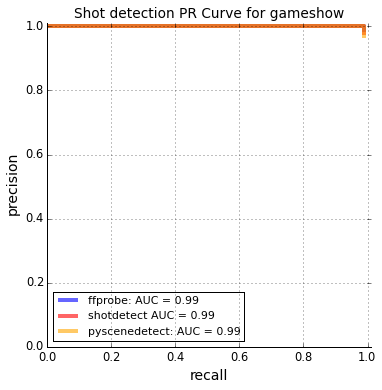

In [28]:
fig, ax = plt.subplots(figsize=(5.8,5.8))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(ff_recall, ff_precision, lw=4, alpha=0.6, color="blue", label='ffprobe: AUC = {}'.format(round(ff_auc, 2)))
plt.plot(sd_recall, sd_precision, lw=4, alpha=0.6, color="red", label='shotdetect AUC = {}'.format(round(sd_auc, 2)))
plt.plot(psd_recall, psd_precision, lw=4, alpha=0.6, color="orange", label='pyscenedetect: AUC = {}'.format(round(psd_auc, 2)))
plt.grid()
plt.legend(loc='lower left', fontsize=11)
plt.title('Shot detection PR Curve for {}'.format(video))
plt.ylim([0,1.01])
plt.xlim([0,1.01])
plt.ylabel('precision', fontsize=14)
plt.xlabel('recall', fontsize=14)
plt.savefig('{}/figures/{}'.format(parent_dir, video))

###Speed benchmarks

**Caveats**: Note that the time benchmarks do not take account of the time cost incurred by parsing the output string, nor do they account for the fact that both ffprobe and Shotdetect are wrapped in Python calls.  However, these time costs should be fairly insignificant in comparison to the shot detection process so these timings may still be of interest.

In [29]:
%%timeit -r 3
ff_predictions = extract_shots_with_ffprobe(src_video, threshold=ffprobe_threshold)

1 loops, best of 3: 2.6 s per loop


In [58]:
%%timeit -r 3
sd_pdrecitions = extract_shots_with_shotdetect(src_video, video, threshold=shotdetect_threshold);

1 loops, best of 3: 21.3 s per loop


In [32]:
%%timeit -r 3
psd_predictions = extract_shots_with_pyscenedetect(src_video, threshold=pyscenedetect_threshold, min_scene_length=15)

[PySceneDetect] Parsing video gameshow.mp4...
[PySceneDetect] Video Resolution / Framerate: 384 x 288 / 25.000 FPS
Verify that the above parameters are correct (especially framerate, use --force-fps to correct if required).
[PySceneDetect] Parsing video gameshow.mp4...
[PySceneDetect] Video Resolution / Framerate: 384 x 288 / 25.000 FPS
Verify that the above parameters are correct (especially framerate, use --force-fps to correct if required).
[PySceneDetect] Parsing video gameshow.mp4...
[PySceneDetect] Video Resolution / Framerate: 384 x 288 / 25.000 FPS
Verify that the above parameters are correct (especially framerate, use --force-fps to correct if required).
[PySceneDetect] Parsing video gameshow.mp4...
[PySceneDetect] Video Resolution / Framerate: 384 x 288 / 25.000 FPS
Verify that the above parameters are correct (especially framerate, use --force-fps to correct if required).
1 loops, best of 3: 5min 27s per loop


###Footabll clip

In [29]:
video = 'football'
TOLERANCE = 0.35 # for football, there are slower shot transitions so a larger tolerance is given

In [30]:
parent_dir = os.path.abspath('..')
src_video = '{}/raw/{}.mp4'.format(parent_dir, video)

load human annotations

In [33]:
annotations_csv = '{}/annotations/{}.csv'.format(parent_dir, video)
gt_shot_boundaries = metrics.get_ground_truth(annotations_csv)
num_pos = len(gt_shot_boundaries)

FFprobe predictions

In [34]:
ff_predictions = extract_shots_with_ffprobe(src_video, threshold=ffprobe_threshold)
ff_ranked_predictions = sorted(ff_predictions, key=lambda x: x[1], reverse=True)
ff_results = metrics.evaluate_shot_predictions(ff_ranked_predictions, gt_shot_boundaries, tolerance=TOLERANCE)
ff_precision, ff_recall = metrics.get_precision_recall(ff_results, num_pos)
ff_auc = auc(ff_recall, ff_precision)

Shotdetect predictions

In [35]:
sd_predictions = extract_shots_with_shotdetect(src_video, video, threshold=shotdetect_threshold)
sd_ranked_predictions = sorted(sd_predictions, key=lambda x: x[1], reverse=True)
sd_results = metrics.evaluate_shot_predictions(sd_ranked_predictions, gt_shot_boundaries, tolerance=TOLERANCE)
sd_precision, sd_recall = metrics.get_precision_recall(sd_results, num_pos)
sd_auc = auc(sd_recall, sd_precision)

PySceneDetect predictions

In [36]:
psd_predictions = extract_shots_with_pyscenedetect(src_video, threshold=pyscenedetect_threshold, min_scene_length=15)
psd_ranked_predictions = sorted(psd_predictions, key=lambda x: x[1], reverse=True)
psd_results = metrics.evaluate_shot_predictions(psd_ranked_predictions, gt_shot_boundaries, tolerance=TOLERANCE)
psd_precision, psd_recall = metrics.get_precision_recall(psd_results, num_pos)
psd_auc = auc(psd_recall, psd_precision)

[PySceneDetect] Parsing video football.mp4...
[PySceneDetect] Video Resolution / Framerate: 640 x 360 / 25.000 FPS
Verify that the above parameters are correct (especially framerate, use --force-fps to correct if required).


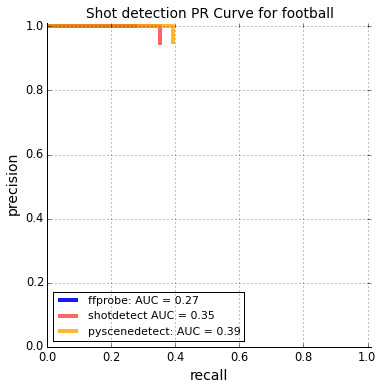

In [37]:
fig, ax = plt.subplots(figsize=(5.8,5.8))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(ff_recall, ff_precision, lw=4, alpha=0.9, color="blue", label='ffprobe: AUC = {}'.format(round(ff_auc, 2)))
plt.plot(sd_recall, sd_precision, lw=4, alpha=0.6, color="red", label='shotdetect AUC = {}'.format(round(sd_auc, 2)))
plt.plot(psd_recall, psd_precision, lw=4, alpha=0.8, color="orange", label='pyscenedetect: AUC = {}'.format(round(psd_auc, 2)))
plt.grid()
plt.legend(loc='lower left', fontsize=11)
plt.title('Shot detection PR Curve for {}'.format(video))
plt.ylim([0,1.01])
plt.xlim([0,1.01])
plt.ylabel('precision', fontsize=14)
plt.xlabel('recall', fontsize=14)
plt.savefig('{}/figures/{}'.format(parent_dir, video))

In [45]:
%%timeit -r 3
ff_predictions = extract_shots_with_ffprobe(src_video, threshold=ffprobe_threshold)

1 loops, best of 3: 6.9 s per loop


In [67]:
%%timeit -r 3
sd_predictions = extract_shots_with_shotdetect(src_video, video, threshold=shotdetect_threshold);

1 loops, best of 3: 45.5 s per loop


In [47]:
%%timeit -r 3
psd_predictions = extract_shots_with_pyscenedetect(src_video, threshold=pyscenedetect_threshold, min_scene_length=15)

[PySceneDetect] Parsing video football.mp4...
[PySceneDetect] Video Resolution / Framerate: 640 x 360 / 25.000 FPS
Verify that the above parameters are correct (especially framerate, use --force-fps to correct if required).
[PySceneDetect] Parsing video football.mp4...
[PySceneDetect] Video Resolution / Framerate: 640 x 360 / 25.000 FPS
Verify that the above parameters are correct (especially framerate, use --force-fps to correct if required).
[PySceneDetect] Parsing video football.mp4...
[PySceneDetect] Video Resolution / Framerate: 640 x 360 / 25.000 FPS
Verify that the above parameters are correct (especially framerate, use --force-fps to correct if required).
[PySceneDetect] Parsing video football.mp4...
[PySceneDetect] Video Resolution / Framerate: 640 x 360 / 25.000 FPS
Verify that the above parameters are correct (especially framerate, use --force-fps to correct if required).
1 loops, best of 3: 1min 57s per loop


###Movie clip

In [38]:
video = 'movie'
TOLERANCE = 0.2 

In [39]:
parent_dir = os.path.abspath('..')
src_video = '{}/raw/{}.mp4'.format(parent_dir, video)

In [40]:
annotations_csv = '{}/annotations/{}.csv'.format(parent_dir, video)
gt_shot_boundaries = metrics.get_ground_truth(annotations_csv)
num_pos = len(gt_shot_boundaries)

ffprobe predictions

In [41]:
ff_predictions = extract_shots_with_ffprobe(src_video, threshold=ffprobe_threshold)
ff_ranked_predictions = sorted(ff_predictions, key=lambda x: x[1], reverse=True)
ff_results = metrics.evaluate_shot_predictions(ff_ranked_predictions, gt_shot_boundaries, tolerance=TOLERANCE)
ff_precision, ff_recall = metrics.get_precision_recall(ff_results, num_pos)
ff_auc = auc(ff_recall, ff_precision)

Shotdetect predictions

In [42]:
sd_predictions = extract_shots_with_shotdetect(src_video, video, threshold=shotdetect_threshold)
sd_ranked_predictions = sorted(sd_predictions, key=lambda x: x[1], reverse=True)
sd_results = metrics.evaluate_shot_predictions(sd_ranked_predictions, gt_shot_boundaries, tolerance=TOLERANCE)
sd_precision, sd_recall = metrics.get_precision_recall(sd_results, num_pos)
sd_auc = auc(sd_recall, sd_precision)

PySceneDetect predictions

In [43]:
psd_predictions = extract_shots_with_pyscenedetect(src_video, threshold=pyscenedetect_threshold, min_scene_length=15)
psd_ranked_predictions = sorted(psd_predictions, key=lambda x: x[1], reverse=True)
psd_results = metrics.evaluate_shot_predictions(psd_ranked_predictions, gt_shot_boundaries, tolerance=TOLERANCE)
psd_precision, psd_recall = metrics.get_precision_recall(psd_results, num_pos)
psd_auc = auc(psd_recall, psd_precision)

[PySceneDetect] Parsing video movie.mp4...
[PySceneDetect] Video Resolution / Framerate: 640 x 256 / 25.000 FPS
Verify that the above parameters are correct (especially framerate, use --force-fps to correct if required).


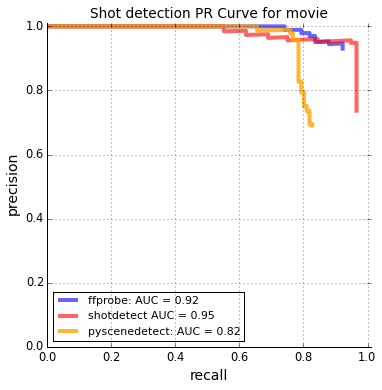

In [44]:
fig, ax = plt.subplots(figsize=(5.8,5.8))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(ff_recall, ff_precision, lw=4, alpha=0.6, color="blue", label='ffprobe: AUC = {}'.format(round(ff_auc, 2)))
plt.plot(sd_recall, sd_precision, lw=4, alpha=0.6, color="red", label='shotdetect AUC = {}'.format(round(sd_auc, 2)))
plt.plot(psd_recall, psd_precision, lw=4, alpha=0.8, color="orange", label='pyscenedetect: AUC = {}'.format(round(psd_auc, 2)))
plt.grid()
plt.legend(loc='lower left', fontsize=11)
plt.title('Shot detection PR Curve for {}'.format(video))
plt.ylim([0,1.01])
plt.xlim([0,1.01])
plt.ylabel('precision', fontsize=14)
plt.xlabel('recall', fontsize=14)
plt.savefig('{}/figures/{}'.format(parent_dir, video))

In [45]:
%%timeit -r 3
ff_predictions = extract_shots_with_ffprobe(src_video, threshold=ffprobe_threshold)

1 loops, best of 3: 2.26 s per loop


In [76]:
%%timeit -r 3
sd_predictions = extract_shots_with_shotdetect(src_video, video, threshold=shotdetect_threshold);

1 loops, best of 3: 20.6 s per loop


In [107]:
%%timeit -r 3
psd_predictions = extract_shots_with_pyscenedetect(src_video, threshold=pyscenedetect_threshold, min_scene_length=15)

[PySceneDetect] Parsing video movie.mp4...
[PySceneDetect] Video Resolution / Framerate: 640 x 256 / 25.000 FPS
Verify that the above parameters are correct (especially framerate, use --force-fps to correct if required).
[PySceneDetect] Parsing video movie.mp4...
[PySceneDetect] Video Resolution / Framerate: 640 x 256 / 25.000 FPS
Verify that the above parameters are correct (especially framerate, use --force-fps to correct if required).
[PySceneDetect] Parsing video movie.mp4...
[PySceneDetect] Video Resolution / Framerate: 640 x 256 / 25.000 FPS
Verify that the above parameters are correct (especially framerate, use --force-fps to correct if required).
[PySceneDetect] Parsing video movie.mp4...
[PySceneDetect] Video Resolution / Framerate: 640 x 256 / 25.000 FPS
Verify that the above parameters are correct (especially framerate, use --force-fps to correct if required).
1 loops, best of 3: 56.8 s per loop
